In [26]:
import sys

from data_helper import ImageGenerator, get_train_matrices, get_test_matrices
from sklearn.cross_validation import train_test_split
from keras_helper import KerasModel
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from itertools import chain

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
img_size = (128, 128)
img_channels = 3
output_size = 17
batch_size = 128
batches = 85 * 128 // batch_size

In [3]:
X_train, y_train, labels_map = get_train_matrices("../data/train_v2.csv", "../data/train-jpg", img_size)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=21)
generator = ImageGenerator()
validation_data = (X_valid, y_valid)
flow = generator.get_train_generator(X_train, y_train, batch_size=batch_size)
gc.collect()

100%|██████████| 40479/40479 [00:35<00:00, 1149.47it/s]


7

In [4]:
from tensorflow.contrib.keras.api.keras.callbacks import ModelCheckpoint

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

In [5]:
model = KerasModel(img_size)
pretrain = True

if pretrain:
    learn_rates = [0.001]#, 0.0001, 0.00001, 0.000001]
    epochs_list = [1]#, 1, 1, 1]
    train_losses, val_losses = [], []

    for lr, epochs in zip(learn_rates, epochs_list):
        tmp_train_losses, tmp_val_losses, fbeta_score, thresholds = model.fit(flow, epochs, lr, validation_data, train_callbacks=[checkpoint], batches=batches)
        train_losses += tmp_train_losses
        val_losses += tmp_val_losses

Epoch 1/1
85/85 [==============================] - 32s - loss: 0.5676 - acc: 0.8183 - val_loss: 0.3086 - val_acc: 0.9059


In [6]:
model.load_weights("weights.best.hdf5")
print("Weights loaded")

Weights loaded


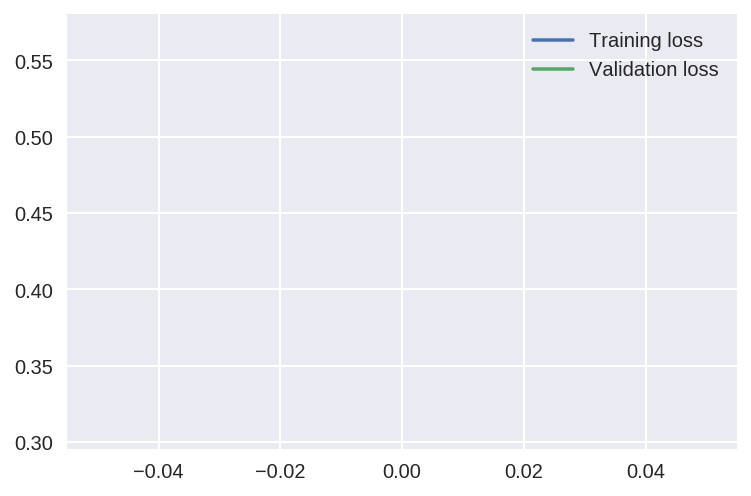

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend();

In [8]:
fbeta_score

0.68846014713140158

In [9]:
del X_train, y_train
gc.collect()

x_test, x_test_filename = get_test_matrices("../data/test-jpg", img_size)
predictions = model.predict(x_test)

del x_test
gc.collect()

x_test, x_test_filename_additional = get_test_matrices("../data/test-jpg-additional", img_size)
new_predictions = model.predict(x_test)

del x_test
gc.collect()

predictions = np.vstack((predictions, new_predictions))
x_test_filename = np.hstack((x_test_filename, x_test_filename_additional))
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              predictions[0]))

100%|██████████| 20522/20522 [01:50<00:00, 185.53it/s]

Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions entry:
[ 0.32128203  0.12281151  0.14029695  0.13429296  0.11416104  0.75824744
  0.15445031  0.13397509  0.17350227  0.164937    0.16281977  0.2129323
  0.85335028  0.22610484  0.11955439  0.12054693  0.21456738]


0 0.0 0.688460147131
1 0.13 0.688460147131
2 0.15 0.688460147131
3 0.14 0.688460147131
4 0.12 0.688460147131
5 0.0 0.688460147131
6 0.16 0.688460147131
7 0.14 0.688460147131
8 0.18 0.688460147131
9 0.17 0.688460147131
10 0.17 0.688460147131
11 0.0 0.688460147131
12 0.0 0.688460147131
13 0.0 0.688460147131
14 0.12 0.688460147131
15 0.13 0.688460147131
16 0.0 0.688460147131


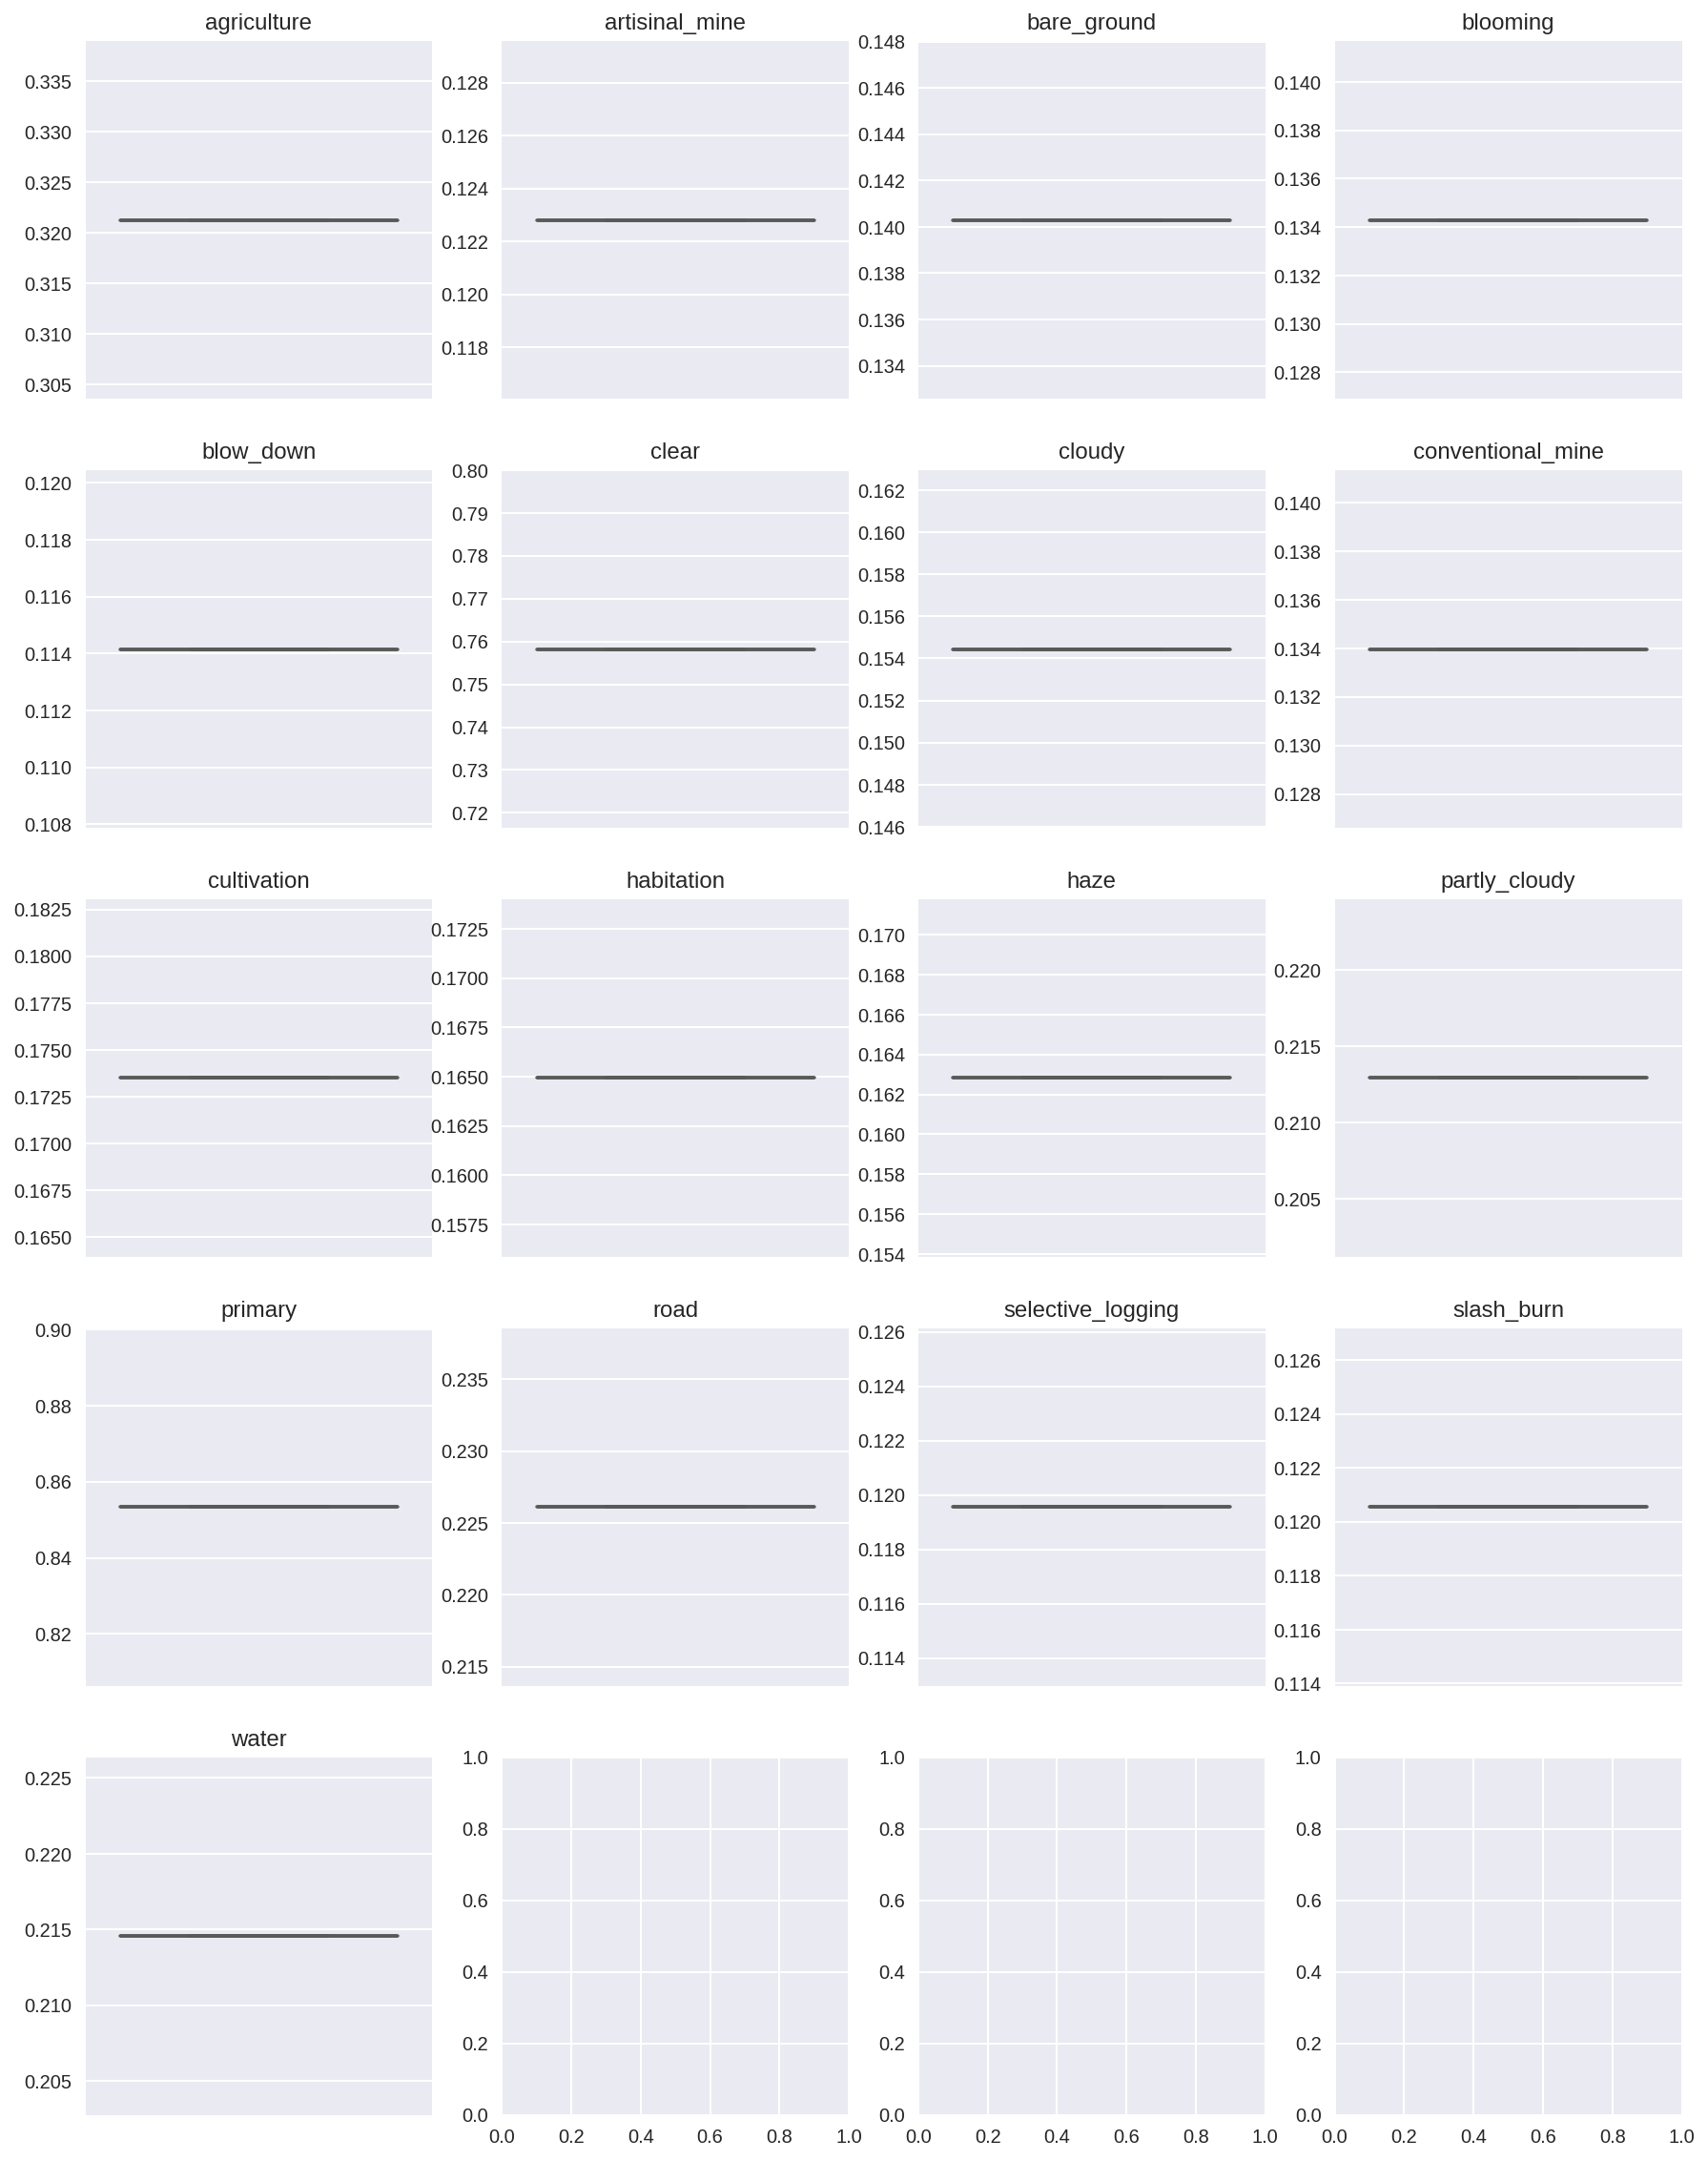

In [10]:
fb_score, thresholds = model.get_fbeta_score(validation_data)

tags_pred = np.array(predictions).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(labels_map[i])

In [11]:
predicted_labels = model.map_predictions(predictions, labels_map, thresholds)

In [12]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [13]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
final_df.head()

,image_name,tags
0,test_22257,agriculture clear partly_cloudy primary road w...
1,test_30541,agriculture clear partly_cloudy primary road w...
2,test_22009,agriculture clear partly_cloudy primary road w...
3,test_23360,agriculture clear partly_cloudy primary road w...
4,test_8741,agriculture clear partly_cloudy primary road w...


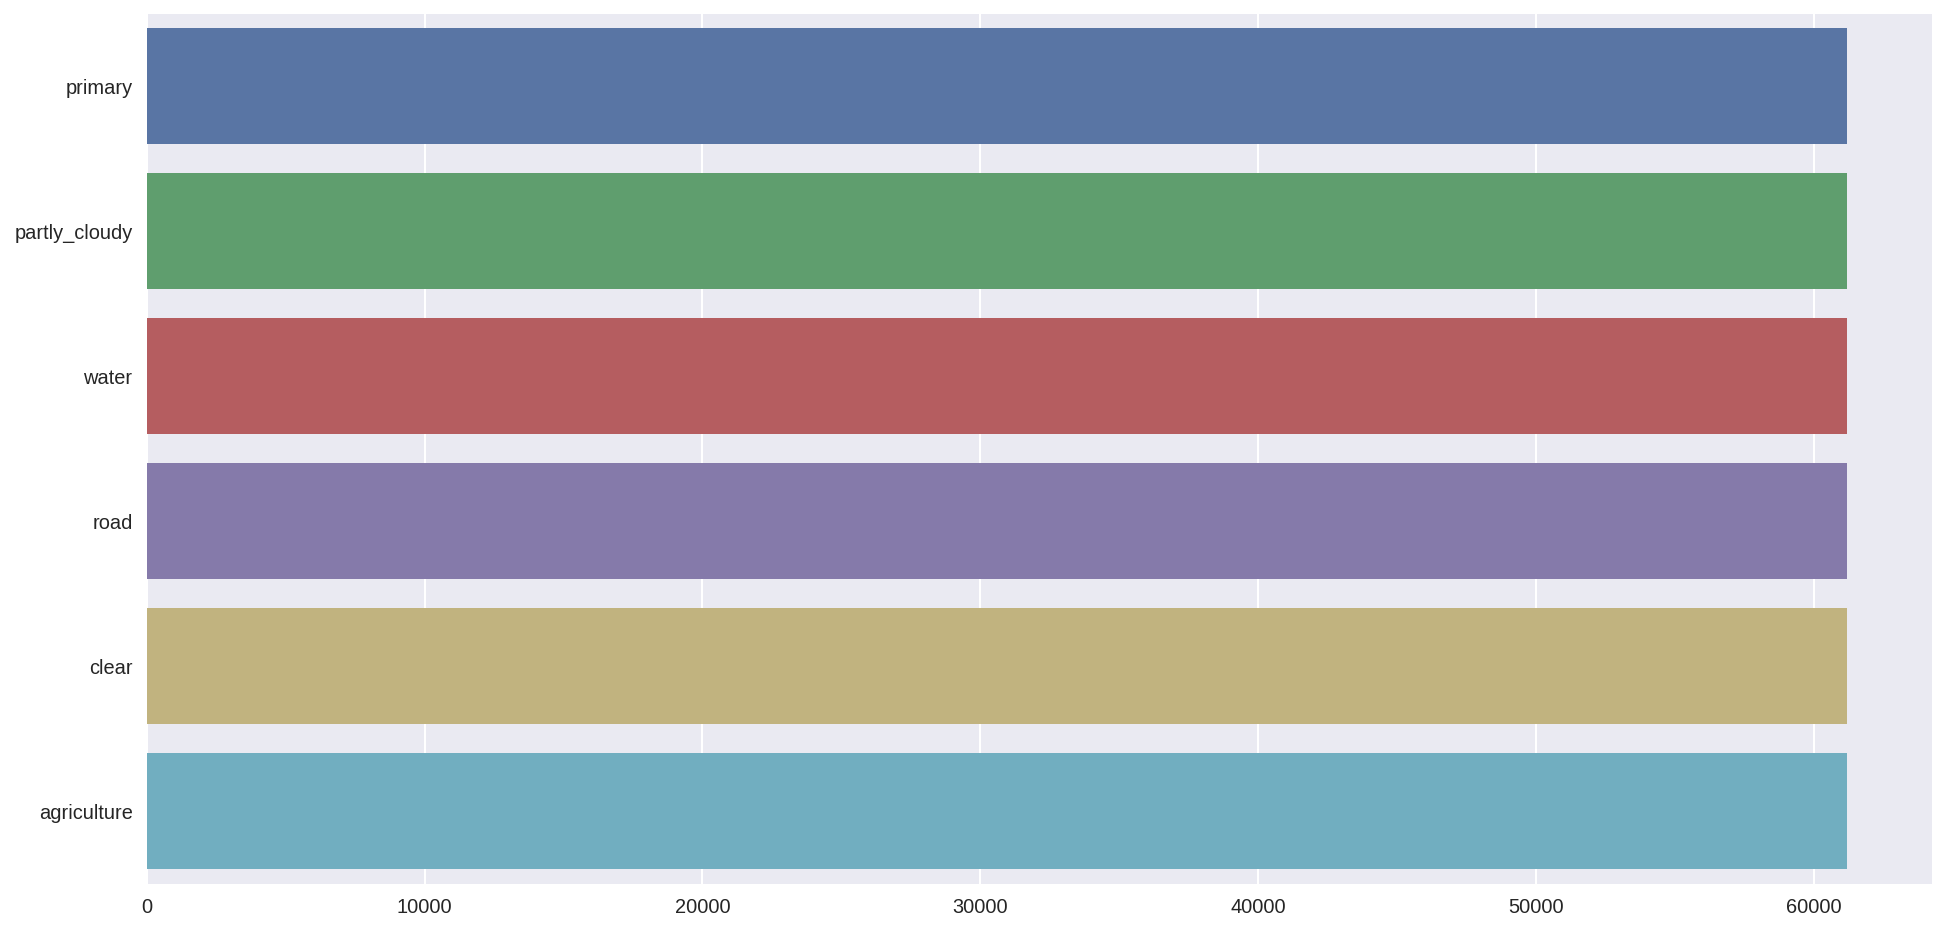

In [14]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

In [15]:
final_df.to_csv('submission_file.csv', index=False)
model.close()